# Install additional packages and set authentication for kaggle API

In [ ]:
!pip install kaggle --q

In [ ]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -U scikit-learn==1.0

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import sparse
import os
import gc
from datetime import datetime
import time
from tqdm import tqdm
import zipfile

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# (1) Test with example sparse matrix 

In [2]:
m = np.array([[0,0,0,0],
           [0,0,0,0],
           [0,0,0,0],
           [2,1,1,1]])

In [3]:
print(m)

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [2 1 1 1]]


In [4]:
csr_m = sparse.csr_matrix(m)

# (2) Create the dummy dataset

In [54]:
def get_data(N = 70_000,num_categorical =40,num_numerical = 10):

  df = pd.DataFrame()
  for i in range(num_categorical):
    df[f"cat_{i}"] = np.random.choice(["A","B","C","D","E",'F',"G","H","I","J","K"],size=N)

  for i in range(num_numerical):
    if i%2==0:
      df[f"num_{i}"] = np.random.randint(low=18,size=N)
    else:
      df[f"num_{i}"] = np.random.uniform(size=N)

  df = pd.get_dummies(df)
  df = df[np.random.default_rng(seed=42).permutation(df.columns.values)]
  df['TARGET'] = np.random.choice([1,0],size=N)

  return df

In [55]:
train = get_data()

In [56]:
train.head()

,cat_29_I,cat_15_I,cat_14_K,cat_17_A,cat_20_B,cat_30_B,cat_32_B,cat_14_E,cat_8_J,cat_12_K,...,cat_20_H,cat_35_B,cat_38_J,cat_0_E,cat_11_K,cat_16_I,cat_2_E,cat_7_K,cat_11_F,TARGET
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [58]:
train.to_csv("train.csv")

In [59]:
del train
gc.collect()

4317

# (3) In-memory and disk size comparison

In [60]:
data = pd.read_csv('train.csv')

In [61]:
disk_usage = os.path.getsize('/content/train.csv')/1e6
memory_usage = data.to_numpy().nbytes/1e6

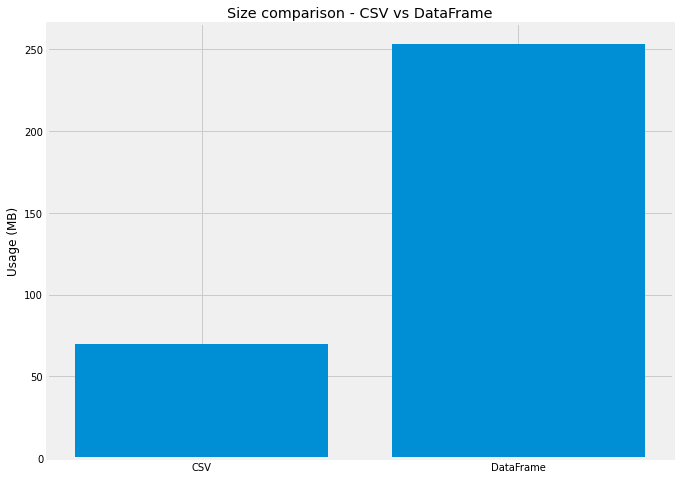

In [62]:
plt.figure(figsize=(10,8))
plt.bar(x=["CSV","DataFrame"],height=[disk_usage,memory_usage])
plt.title("Size comparison - CSV vs DataFrame")
plt.ylabel("Usage (MB)")
plt.show()

# (4) Check sparsity of the dataset

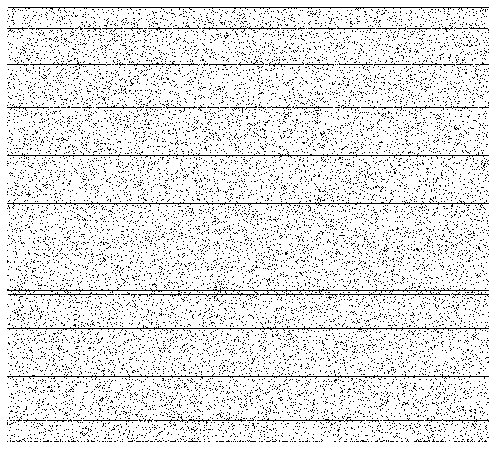

In [63]:
plt.figure(figsize=(8,8))
plt.spy(data.head(500).T)
plt.axis('off')
plt.grid(False)
plt.show()

In [64]:
sparsity = 1- np.count_nonzero(data)/ data.size

In [65]:
sparsity

0.8866724715549936

# (5) Check compression effect on test and train datasets

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier,BaggingClassifier,RandomForestClassifier,HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

TEST_SIZE = 0.3

In [67]:
y = data.pop('TARGET')
X = data

In [68]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=TEST_SIZE,random_state=1997)

In [69]:
def get_mem_usage(train,test,labels=['Train','Test'],plot=True):
    
    """Helper function for plotting in-disk memory usage for pandas df"""
    
    #get the original memory usage 
    train_original_size = train.to_numpy().nbytes/1e6
    test_original_size = test.to_numpy().nbytes/1e6
    
    #convert into csr_metrix
    train_csr = sparse.csr_matrix(train)
    test_csr = sparse.csr_matrix(test)
    
    #get memory usage
    train_csr_size = (train_csr.data.nbytes+train_csr.indptr.nbytes+train_csr.indices.nbytes)/1e6
    test_csr_size = (test_csr.data.nbytes+test_csr.indptr.nbytes+test_csr.indices.nbytes)/1e6
    
    original_sizes = [train_original_size, test_original_size]
    sparse_sizes = [train_csr_size, test_csr_size]
    
    if plot:
        width = 0.35
        x = np.arange(len(labels))

        fig, ax = plt.subplots(figsize=(10,8))

        rects1 = ax.bar(x - width/2, original_sizes, width, label='Original')
        rects2 = ax.bar(x + width/2, sparse_sizes, width, label='Sparse')

        ax.set_ylabel('Memory Usage(MB)')
        ax.set_title('Memory Usage Comparison'.title())
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        plt.grid(False)
        plt.show()

    else:
        return sparse_sizes+original_sizes

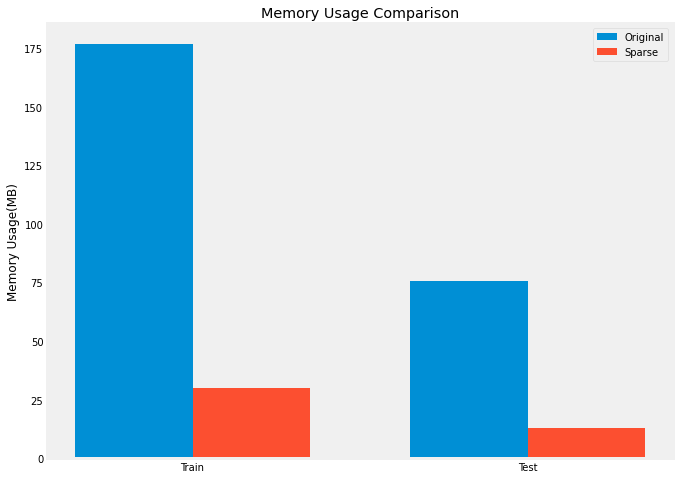

In [70]:
get_mem_usage(xtrain,xtest)

# (6) Plot sample size vs memory usage

In [ ]:
def sample_size_comparison(X,y):
    
    """Helper function for evaluate model training time with regards of samples and in-memory dataset type"""
    
    sample_sizes = np.arange(start=1000,stop=len(data)+1,step=1000)
    X = X.copy()
    
    sample_size_comparison = dict()
    
    for n_samples in tqdm(sample_sizes):
        xtrain,xtest = train_test_split(X.sample(n_samples,replace=True),test_size=TEST_SIZE,random_state=1997)
        sample_size_comparison[str(n_samples)] = get_mem_usage(xtrain,xtest,plot=False)
    
    result = pd.DataFrame(sample_size_comparison.items())
    result = result.set_index(0)
    result = pd.DataFrame(result[1].tolist(), index= result.index,columns=['train_csr_size', 'test_csr_size','train_original_size', 'test_original_size'])
    return result[['train_csr_size','train_original_size']]

In [ ]:
res = sample_size_comparison(X,y)

100%|██████████| 76/76 [00:35<00:00,  2.14it/s]


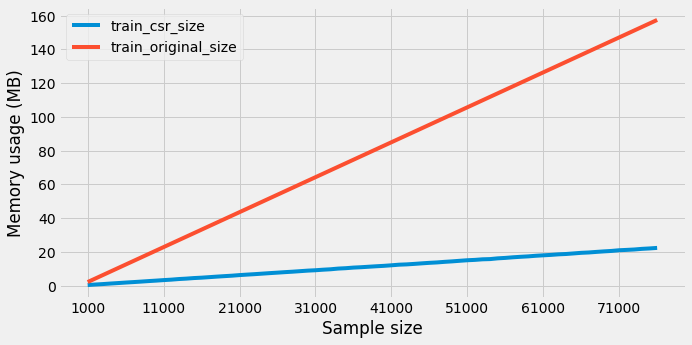

In [ ]:
_,axi = plt.subplots(figsize=(10,5))

ax1 = res.plot(linestyle='solid',ax=axi)
axi.set_xlabel("Sample size")
axi.set_ylabel("Memory usage (MB)")

plt.show()

# (7) Get model train time

In [75]:
def sparse_method(df):
    return sparse.csr_matrix(df,dtype=np.float32)

def ndarray_method(df):
    return df.copy()

In [76]:
csr_X = sparse_method(X)

In [85]:
def model_fit_time_comparison(model,X,y):
    
    """Helper function for train models againt ndarrays and csr_metrics"""
    
    fit_time_comparison = dict()
    
    for method in tqdm([sparse_method,ndarray_method]):
        X,y = method(X),y
        
        st = time.time()
        model.fit(X,y)
        et = time.time()
        
        fit_time = (et-st)
        fit_time_comparison[method.__name__] = fit_time
        
    return fit_time_comparison

In [100]:
def model_preformance(df_time,sparse_time,model_name,labels=['Original','Sparse Metrix']):
  plot = True
  if plot:
      width = 0.35
      x = np.arange(len(labels))

      fig, ax = plt.subplots(figsize=(10,8))

      rects1 = ax.bar(labels, [df_time,sparse_time], width)
      # rects2 = ax.bar(x + width/2, sparse_sizes, width, label='Sparse')

      ax.set_ylabel('Train time (Seconds)')
      ax.set_title(f'Model Training Time Comparison\n\n{model_name}')
      ax.set_xticks(x)
      ax.set_xticklabels(labels)
      # ax.legend()

      # plt.grid(False)
      plt.show()

  else:
      return sparse_sizes+original_sizes

## LogisticResgression

In [89]:
model_lr = LogisticRegression()
%time model_lr.fit(X,y)

CPU times: user 2.5 s, sys: 252 ms, total: 2.75 s
Wall time: 1.51 s


LogisticRegression()

In [90]:
model_lr = LogisticRegression()
%time model_lr.fit(csr_X,y)

CPU times: user 453 ms, sys: 65 µs, total: 453 ms
Wall time: 456 ms


LogisticRegression()

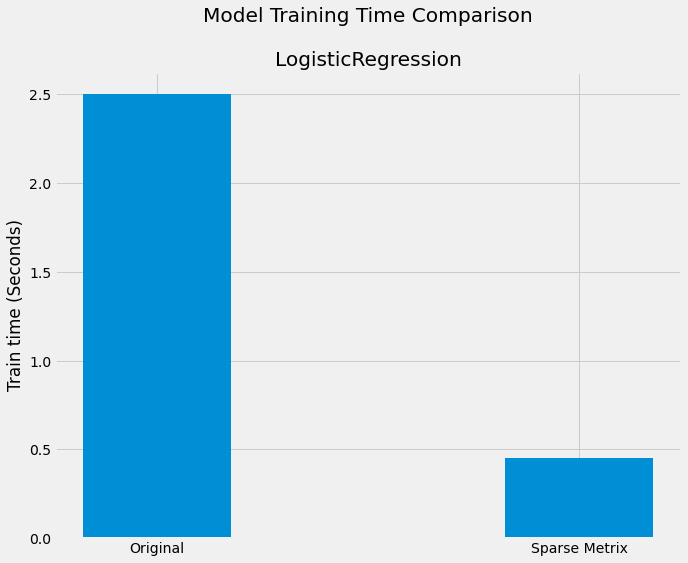

In [101]:
model_preformance(df_time=2.5,sparse_time=0.453,model_name='LogisticRegression')

## GradientBoostingClassifier

In [91]:
model_gb = GradientBoostingClassifier()
%time  model_gb.fit(X,y)

CPU times: user 1min 24s, sys: 2.85 ms, total: 1min 24s
Wall time: 1min 24s


GradientBoostingClassifier()

In [92]:
model_gb = GradientBoostingClassifier()
%time model_gb.fit(csr_X,y)

CPU times: user 50.8 s, sys: 73.7 ms, total: 50.9 s
Wall time: 50.7 s


GradientBoostingClassifier()

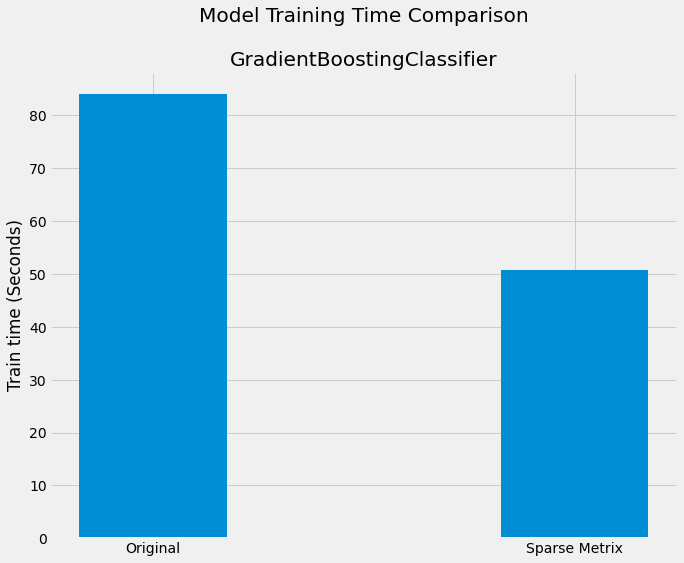

In [108]:
model_preformance(df_time=84,sparse_time=50.8,model_name='GradientBoostingClassifier')

## KMeans

In [93]:
cluster_model = KMeans()
%time cluster_model.fit(X,y)

CPU times: user 1min 9s, sys: 1.26 s, total: 1min 10s
Wall time: 36.5 s


KMeans()

In [94]:
cluster_model = KMeans()
%time cluster_model.fit(csr_X,y)

CPU times: user 21.4 s, sys: 145 ms, total: 21.6 s
Wall time: 15.3 s


KMeans()

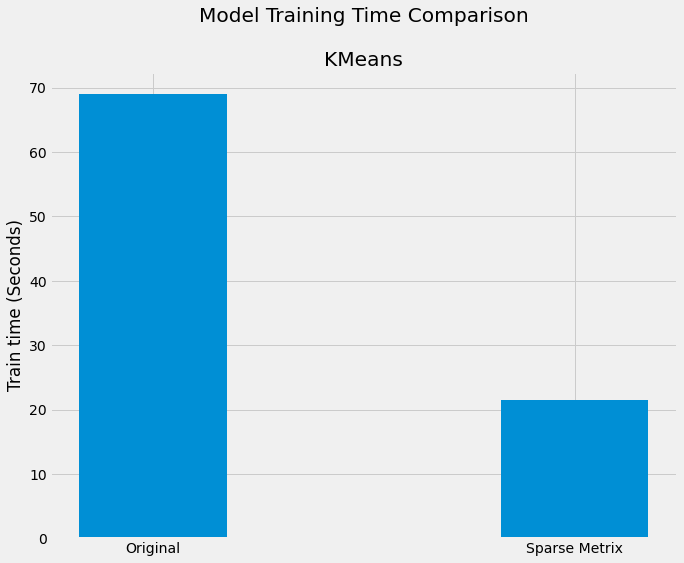

In [104]:
model_preformance(df_time=69,sparse_time=21.4,model_name='KMeans')

## LinearSVC

In [105]:
sv = LinearSVC()
%time sv.fit(X,y)

CPU times: user 45.1 s, sys: 65.5 ms, total: 45.2 s
Wall time: 45 s


LinearSVC()

In [96]:
sv = LinearSVC()
%time sv.fit(csr_X,y)

CPU times: user 41.6 s, sys: 24.3 ms, total: 41.6 s
Wall time: 41.5 s


LinearSVC()

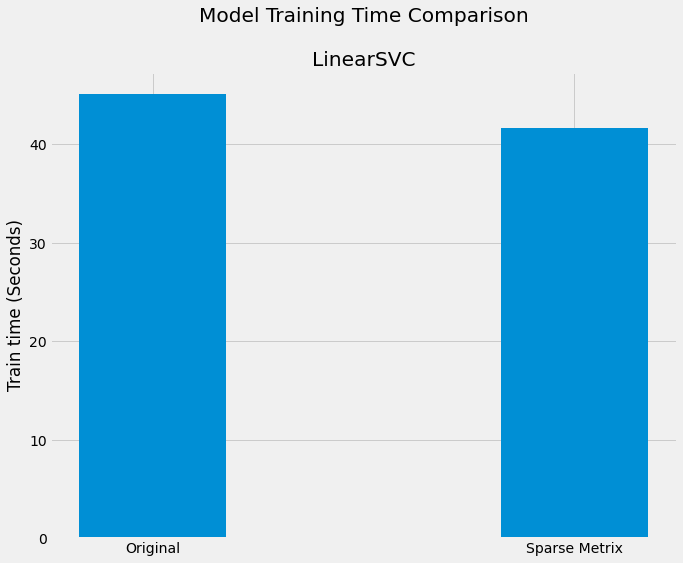

In [107]:
model_preformance(df_time=45.1,sparse_time=41.6,model_name='LinearSVC')